In [16]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree



from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data = pd.read_csv('immo_data.csv')
data

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.40,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.00,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.0,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.90,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268845,Bayern,90.00,heat_pump,ONE_YEAR_FREE,NaN,False,True,0,2.74,10.0,910.0,2016.0,115641081,1.0,geothermal,False,Bayern,True,9.0,820.0,NaN,90.00,Weilheim_Schongau_Kreis,mint_condition,sophisticated,no,no_information,NaN,False,6,roof_storey,82390,3.0,NaN,NaN,NaN,3,False,4,Weilheim_Schongau_Kreis,Eberfing,"Diese schöne, neuwertige Wohnung im Dachgescho...",Fliesen und Parkett. Sichtbarer Dachstuhl.,NaN,NaN,NaN,NaN,NaN,Feb20
268846,Hessen,220.00,gas_heating,NaN,NaN,False,True,12,6.49,NaN,1150.0,1983.0,96981497,1.0,gas,True,Hessen,False,4.0,930.0,NaN,115.00,Bergstraße_Kreis,well_kept,sophisticated,negotiable,no_information,NaN,False,6,apartment,68519,3.5,NaN,1.0,1.0,3,False,5,Bergstraße_Kreis,Viernheim,Hier wird eine Wohnung im 2 Familienhaus angeb...,"Parkett, Kamin, Badewanne&Dusche\nGroßer Balko...",NaN,NaN,2015.0,NaN,NaN,May19
268847,Hessen,220.00,central_heating,ONE_YEAR_FREE,NaN,False,True,21,2.90,40.0,930.0,1965.0,66924271,1.0,gas,False,Hessen,True,2.0,650.0,10,95.00,Limburg_Weilburg_Kreis,well_kept,NaN,negotiable,Emsbachstrasse,Emsbachstrasse,False,5,apartment,65552,4.0,160.77,1.0,2.0,4,True,4,Limburg_Weilburg_Krei

In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

In [4]:
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [5]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop high-cardinality categorical columns
    df = df.drop(['houseNumber', 'street', 'streetPlain', 'regio3', 'description', 'facilities'], axis=1)
    
    # Drop columns with more than 25% missing values
    missing_value_columns = df.loc[:, df.isna().mean() > 0.25].columns
    df = df.drop(missing_value_columns, axis=1)
    
    # Drop examples with missing label values
    missing_label_rows = df.loc[df['typeOfFlat'].isna(), :].index
    df = df.drop(missing_label_rows, axis=0).reset_index(drop=True)
    
    # Construct label column
    df['isApartment'] = df['typeOfFlat'].apply(lambda x: 1 if x == 'apartment' else 0)
    df = df.drop('typeOfFlat', axis=1)
    
    # Get columns with remaining missing values
    remaining_na_columns = df.loc[:, df.isna().sum() > 0]
    categorical_na_columns = remaining_na_columns.select_dtypes('object').columns
    numeric_na_columns = remaining_na_columns.drop(categorical_na_columns, axis=1).columns
    
    # Fill numeric missing values with column mean
    for column in numeric_na_columns:
        df[column] = df[column].fillna(df[column].mean())
    
    # Fill categorical missing values with "missing"
    for column in categorical_na_columns:
        df[column] = df[column].fillna("missing")
    
    # Convert booleans columns to int columns
    for column in df.columns:
        if df[column].dtype == 'bool':
            df[column] = df[column].astype(np.int)
    
    # Extract date features
    df['date'] = pd.to_datetime(df['date'], format='%b%y')
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df = df.drop('date', axis=1)
    
    # One-hot encode
    for column in df.select_dtypes('object'):
        df = onehot_encode(df, column)
    
    # Split df into X and y
    y = df['isApartment']
    X = df.drop('isApartment', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    
    return X_train, X_test, y_train, y_test

In [12]:
def evaluate_model(classifier, X_test, y_test):
    
    model = classifier.fit(X_train,y_train)


    
    y_pred = np.squeeze(np.array(model.predict(X_test) >= 0.5, dtype=np.int))
    
    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred, target_names=["NOT APARTMENT", "APARTMENT"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["NOT APARTMENT", "APARTMENT"])
    plt.yticks(np.arange(2) + 0.5, ["NOT APARTMENT", "APARTMENT"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [7]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)


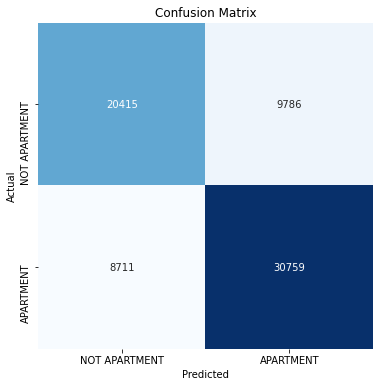

Classification Report:
----------------------
                precision    recall  f1-score   support

NOT APARTMENT       0.70      0.68      0.69     30201
    APARTMENT       0.76      0.78      0.77     39470

     accuracy                           0.73     69671
    macro avg       0.73      0.73      0.73     69671
 weighted avg       0.73      0.73      0.73     69671



In [13]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth= 15, min_samples_leaf= 3)
evaluate_model(clf, X_test, y_test)


#RandomForestClassifier

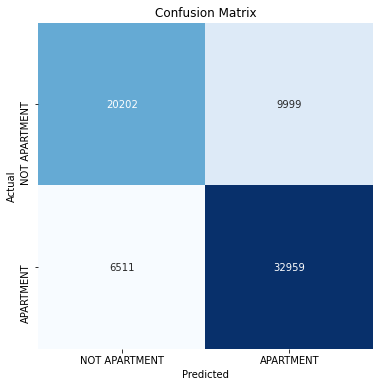

Classification Report:
----------------------
                precision    recall  f1-score   support

NOT APARTMENT       0.76      0.67      0.71     30201
    APARTMENT       0.77      0.84      0.80     39470

     accuracy                           0.76     69671
    macro avg       0.76      0.75      0.75     69671
 weighted avg       0.76      0.76      0.76     69671



In [14]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=105)
evaluate_model(rf, X_test, y_test)


#Logistic Regression

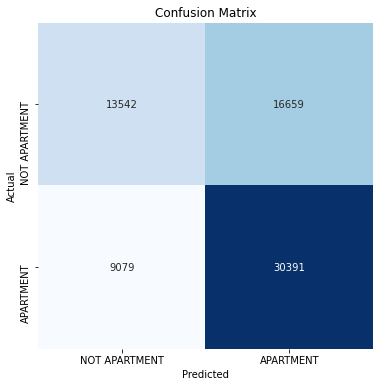

Classification Report:
----------------------
                precision    recall  f1-score   support

NOT APARTMENT       0.60      0.45      0.51     30201
    APARTMENT       0.65      0.77      0.70     39470

     accuracy                           0.63     69671
    macro avg       0.62      0.61      0.61     69671
 weighted avg       0.63      0.63      0.62     69671



In [19]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(penalty= 'l1', class_weight= {1: 0.5, 0: 0.5}, C= 10, solver='liblinear')
evaluate_model(logreg, X_test, y_test)


In [21]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

clf.fit(X_train, y_train)
rf.fit(X_train, y_train)
logreg.fit(X_train, y_train)



# predict probabilities
pred_prob1 = clf.predict_proba(X_test)[::,1]
pred_prob2 = rf.predict_proba(X_test)[::,1]
pred_prob3 = logreg.predict_proba(X_test)[::,1]



from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2, pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3, pos_label=1)




# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1)
auc_score2 = roc_auc_score(y_test, pred_prob2)
auc_score3 = roc_auc_score(y_test, pred_prob3)

print(auc_score1, auc_score2, auc_score3)

0.7877350461476555 0.8403339484251227 0.6709132722590415


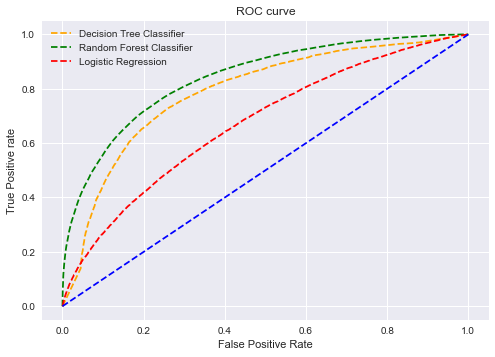

In [22]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Decision Tree Classifier')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Random Forest Classifier')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='Logistic Regression')



plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC_Curve',dpi=300)
plt.show();

<AxesSubplot:>

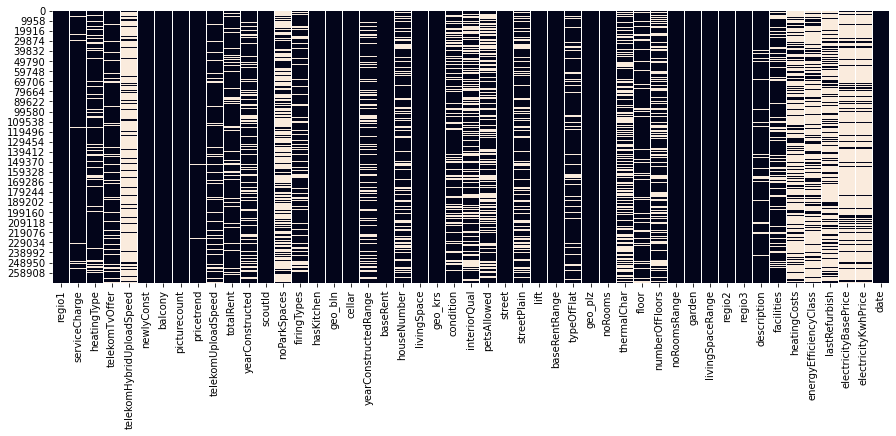

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


#Checking missing values
plt.figure(figsize=(15,5))
sns.heatmap(data.isna(),cbar=False)